https://github.com/thu-ml/zhusuan/blob/master/examples/bayesian_neural_nets/bayesian_nn.py

In [1]:
import numpy as np

In [2]:
import edward as ed
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
import numpy as np
import tensorflow as tf

from edward.models import Normal, Empirical

In [5]:
ed.set_seed(12)
sns.set()
%matplotlib inline

In [6]:
# Our model will be a two-layer neural network.
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.matmul(x, W_0) + b_0
    h = tf.tanh(h)
    #h = tf.exp(tf.negative(tf.square(h)))
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

def display_draws(x_data, y_data, draw_inputs, draw_outputs, label):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(x_data, y_data, 'ks', alpha=0.5, label='(x, y)')
    ax.plot(draw_inputs, draw_outputs[0].T, 'r', lw=2, alpha=0.5, label=label)
    ax.plot(draw_inputs, draw_outputs[1:].T, 'r', lw=2, alpha=0.5)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-2, 3])
    ax.legend()
    plt.show()

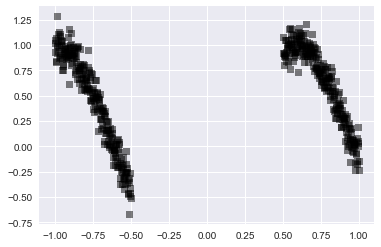

In [7]:
x_train = np.concatenate([np.linspace(0, 2, num=250),
                           np.linspace(6, 8, num=250)])
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=500)
x_train = (x_train - 4.0) / 4.0
x_train = x_train.reshape((500,1))

plt.plot(x_train, y_train, 'ks', alpha=0.5)

In [8]:
# Build a Bayesian Neural Network with normal priors over weights
W_0 = Normal(loc=tf.zeros([1, 20]), scale=tf.ones([1, 20]))
W_1 = Normal(loc=tf.zeros([20, 1]), scale=tf.ones([20, 1]))
b_0 = Normal(loc=tf.zeros(20), scale=tf.ones(20))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = tf.placeholder(tf.float32, (500,1))
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1), scale=0.1*tf.ones(500))

In [9]:
# Posterior approximators
qW_0 = Normal(loc=tf.Variable(tf.random_normal([1, 20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1, 20]))))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([20, 1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20, 1]))))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20]))))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [10]:
# Sample neural networks from our variational model.
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, num=500, dtype=np.float32)
nx = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [neural_network(nx, qW_0.sample(), qW_1.sample(), qb_0.sample(), qb_1.sample())
     for _ in range(4)])

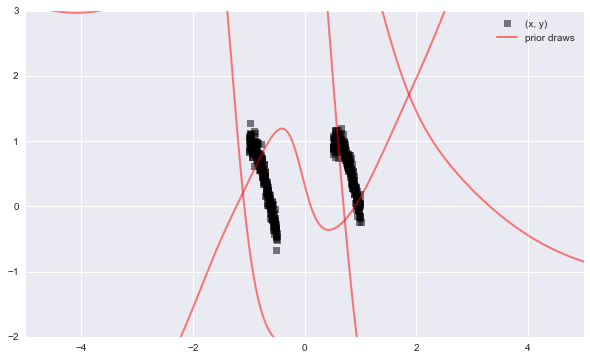

In [11]:
# Visualize prior draws.
sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()
display_draws(x_train, y_train, inputs, outputs, 'prior draws')

In [13]:
%run optim.py

# Using AdamOptim

In [33]:
# Training: Minimize the KL-divergence of our posterior approximators.
inference = test({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1},
                    data={x: x_train, y: y_train})

In [50]:
optimizer = tf.train.AdamOptimizer(5e-3)

In [51]:
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

In [36]:
sess = ed.get_session()
tf.global_variables_initializer().run()

In [37]:
x_ph = tf.placeholder(tf.float32, (500,1))
y_ph = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1), scale=0.1*tf.ones(500))

In [38]:
n_epoch = 10000
train_loss = np.zeros(n_epoch)

In [39]:
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={x_ph: x_train, y_ph: y_train})
  train_loss[i] = info_dict['loss']
  inference.print_progress(info_dict)

1000/1000 [100%] ██████████████████████████████ Elapsed: 24s | Loss: 218901.656

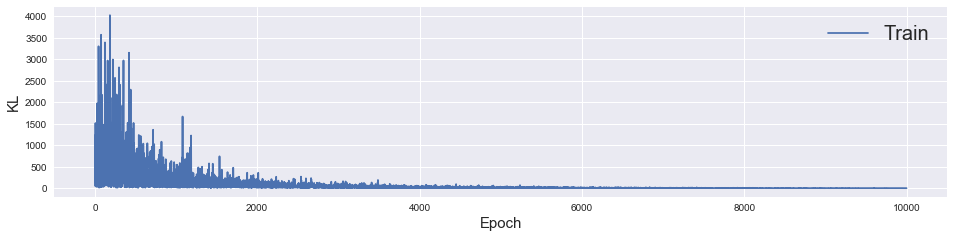

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), train_loss / len(x_train), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('KL', fontsize=15)
plt.show()

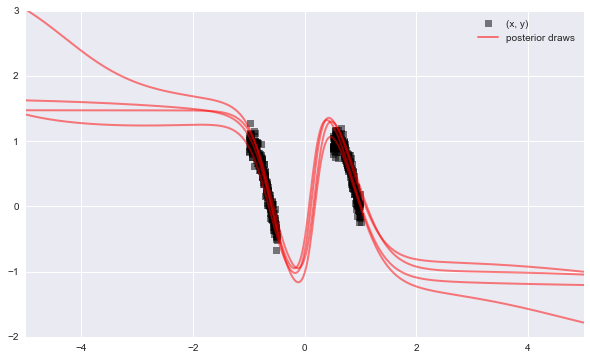

In [41]:
# Visualize posterior draws.
outputs = mus.eval()
display_draws(x_train, y_train, inputs, outputs, 'posterior draws')

# Using SGD

In [123]:
# Training: Minimize the KL-divergence of our posterior approximators.
inference = test({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1},
                    data={x: x_train, y: y_train})

In [125]:
learning_rate=5e-8

In [130]:
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

In [88]:
optimizer = tf.train.GradientDescentOptimizer(5e-8)

In [89]:
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())
sess = ed.get_session()
tf.global_variables_initializer().run()

In [121]:
x_ph = tf.placeholder(tf.float32, (500,1))
y_ph = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1), scale=0.1*tf.ones(500))
n_epoch = 200
train_loss = np.zeros(n_epoch)

In [122]:
for i in range(n_epoch):
  data = np.random.randint(1,len(x_train),1)[0]
  info_dict = inference.update(feed_dict={x_ph: x_train, y_ph: y_train})
  train_loss[i] = info_dict['loss']
  inference.print_progress(info_dict)

2210/1000 [221%] ██████████████████████████████████████████████████████████████████ Elapsed: 1407s | Loss: 6136.463 
2220/1000 [222%] ██████████████████████████████████████████████████████████████████ Elapsed: 1407s | Loss: 117178.461
2230/1000 [223%] ██████████████████████████████████████████████████████████████████ Elapsed: 1407s | Loss: 6166.413  
2240/1000 [224%] ███████████████████████████████████████████████████████████████████ Elapsed: 1407s | Loss: 26023.760
2250/

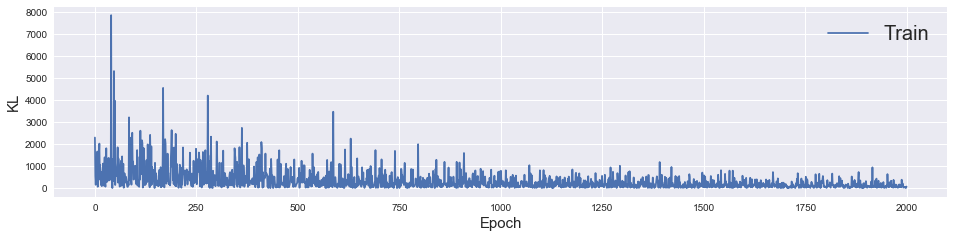

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), train_loss / len(x_train), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('KL', fontsize=15)
plt.show()

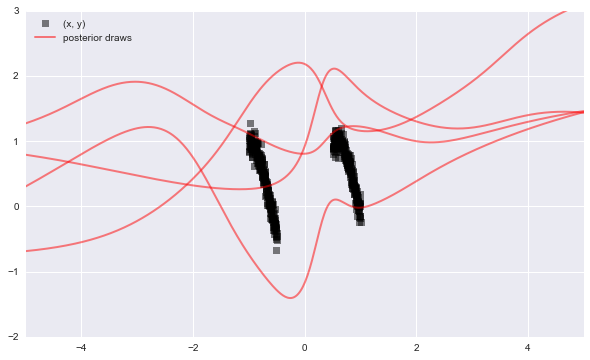

In [93]:
# Visualize posterior draws.
outputs = mus.eval()
display_draws(x_train, y_train, inputs, outputs, 'posterior draws')

# Using KLqp (Edward)

5000/5000 [100%] ██████████████████████████████ Elapsed: 13s | Loss: 1519.829 

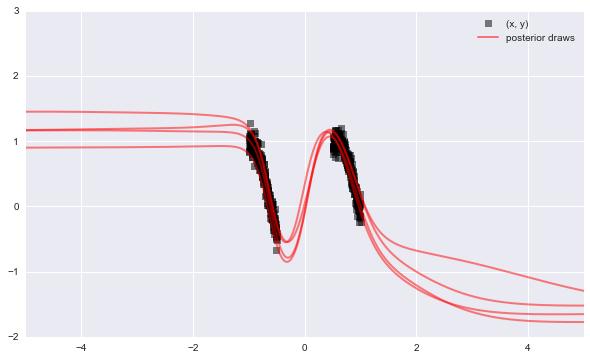

In [23]:
# Training: Minimize the KL-divergence of our posterior approximators.
inference = test({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1},
                    data={x: x_train, y: y_train})
inference.run(n_iter=5000)
# Visualize posterior draws.
outputs = mus.eval()
display_draws(x_train, y_train, inputs, outputs, 'posterior draws')

In [16]:
%run elbo_optimizer.py

In [17]:
# Training: Minimize the KL-divergence of our posterior approximators.
inference = test({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1},
                    data={x: x_train, y: y_train})

In [18]:
inference.run(n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 13s | Loss: 189.539

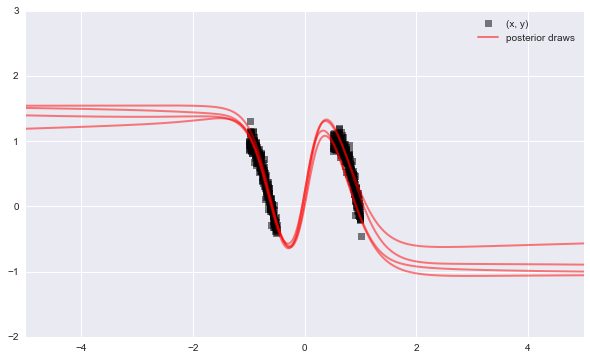

In [19]:
# Visualize posterior draws.
outputs = mus.eval()
display_draws(x_train, y_train, inputs, outputs, 'posterior draws')